In [1]:
# !pip install alibi alibi_detect

In [7]:
# !pip install tensorflow
# !pip install tensorflow_probability
# !pip install tf_keras

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ------------ --------------------------- 0.5/1.7 MB 10.9 MB/s eta 0:00:01
   ------------------------------- -------- 1.3/1.7 MB 14.2 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 15.7 MB/s eta 0:00:00


In [1]:
import alibi
from alibi_detect.cd import ChiSquareDrift, TabularDrift
from alibi_detect.saving import save_detector, load_detector

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn

#### Reading Training and Production datasets from Git repo

In [5]:
# Setting up the urls for training and Test Dataset

ftr_trn_url = 'https://raw.githubusercontent.com/swarnkarnitin/MLOps/Main/Datasets/features_train.parquet'
ftr_prd_url = 'https://raw.githubusercontent.com/swarnkarnitin/MLOps/Main/Datasets/features_prod.parquet'
tgt_trn_url = 'https://raw.githubusercontent.com/swarnkarnitin/MLOps/Main/Datasets/target_train.parquet'
tgt_prd_url = 'https://raw.githubusercontent.com/swarnkarnitin/MLOps/Main/Datasets/target_prod.parquet'

# Reading dataset from Git
ftr_trn_df = pd.read_parquet(ftr_trn_url, engine='auto')
ftr_prd_df = pd.read_parquet(ftr_prd_url, engine='auto')
tgt_trn_df = pd.read_parquet(tgt_trn_url, engine='auto')
tgt_prd_df = pd.read_parquet(tgt_prd_url, engine='auto')

In [28]:
# Creating column list
x_features = list(ftr_trn_df.columns)
x_features

['age', 'sex', 'bmi', 'children', 'smoker', 'region']

In [45]:
#Defining the index of categorical features
cat_vars = [1, 4, 5]

In [43]:

categories_per_feature = {f: None for f in cat_vars}

In [49]:
# Preparing the dictionay of categorical features
categories_per_feature

{1: None, 4: None, 5: None}

#### Measuring drift

In [13]:
# Calling Tabular drift function at 0.05 cut-off
cd = TabularDrift(ftr_trn_df.values,
                  p_val=.05,
                  categories_per_feature=categories_per_feature)

In [15]:
import dill
import tensorflow
from tensorflow.keras.layers import Input, InputLayer

#Creating folder to save the drift
filepath = 'insurancedrift'  # change to directory where detector is saved
save_detector(cd, filepath, legacy = True)

Directory insurancedrift does not exist and is now created.


In [18]:
cd = load_detector(filepath)

No model found in insurancedrift\model, setting `model` to `None`.


In [22]:
preds = cd.predict(ftr_prd_df.to_numpy())

In [30]:
#Setting drift measure as Chi for categorical feature and k-5 for numerical

for f in range(cd.n_features):
    stat = 'Chi2' if f in list(categories_per_feature.keys()) else 'K-S'
    fname = x_features[f]
    stat_val, p_val = preds['data']['distance'][f], preds['data']['p_val'][f]
    print(f'{fname} -- {stat} {stat_val:.3f} -- p-value {p_val:.3f}')

age -- K-S 0.054 -- p-value 0.584
sex -- Chi2 0.001 -- p-value 0.973
bmi -- K-S 0.053 -- p-value 0.599
children -- K-S 0.025 -- p-value 0.999
smoker -- Chi2 0.000 -- p-value 1.000
region -- Chi2 8.172 -- p-value 0.043


In [34]:
ftr_trn_df.region.value_counts()

region
southwest    214
southeast    202
northeast    201
northwest    185
Name: count, dtype: int64

In [37]:
ftr_prd_df.region.value_counts()

region
southeast    81
northwest    71
northeast    66
southwest    50
Name: count, dtype: int64

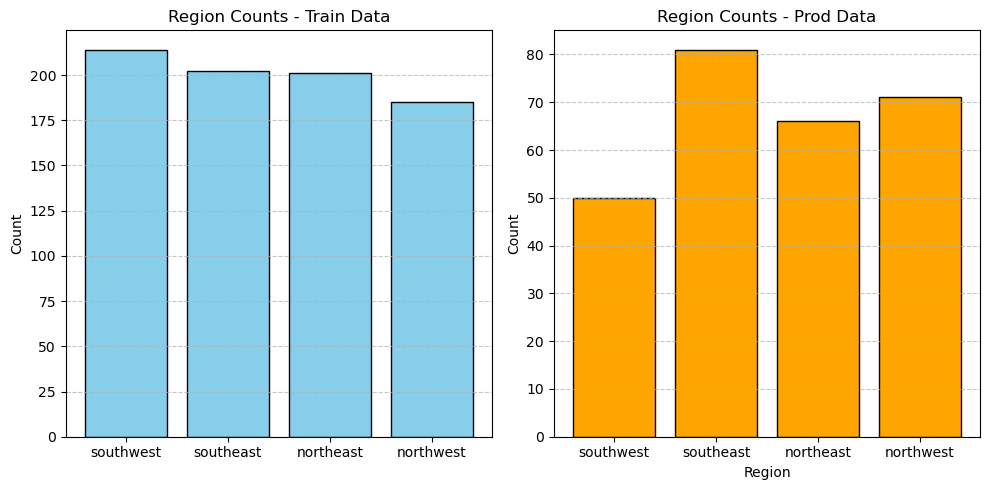

In [101]:
import matplotlib.pyplot as plt
import numpy as np

trn_region_counts = ftr_trn_df['region'].value_counts()
prd_region_counts = ftr_prd_df['region'].value_counts()

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(10,5), sharex=True)

# Plot for ftr_trn_df
axes[0].bar(trn_region_counts.index, trn_region_counts.values, color='skyblue', edgecolor='black')
axes[0].set_title('Region Counts - Train Data')
axes[0].set_ylabel('Count')
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot for ftr_prd_df
axes[1].bar(prd_region_counts.index, prd_region_counts.values, color='orange', edgecolor='black')
axes[1].set_title('Region Counts - Prod Data')
axes[1].set_xlabel('Region')
axes[1].set_ylabel('Count')
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()

#### Above chart depicts the drift in Production data set as compare to training datase
#### In Production Dataset Southwest has lowest value 
#### and other region also don't follow the distribution of training dataset

In [39]:
ftr_trn_df.smoker.value_counts()

smoker
no     637
yes    165
Name: count, dtype: int64

In [41]:
ftr_prd_df.smoker.value_counts()

smoker
no     213
yes     55
Name: count, dtype: int64